# Computing the energy of water on IBM

## Set experiment parameters

In [1]:
ibm_computer: str = "ibm_fez"
qubits = [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124]
nshots: int = 50_000

len(qubits)

14

## Setup

In [2]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np
import pickle

import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-24 16:38:18,183: Default instance not set. Searching all available instances.


## Read in the Hamiltonian and ansatz circuit

In [13]:
hamiltonian = of.jordan_wigner(
        of.get_fermion_operator(
    of.chem.MolecularData(filename="monomer_eqb.hdf5").get_molecular_hamiltonian()
    )
)
nqubits = of.utils.count_qubits(hamiltonian)
nterms  = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1620 term(s).


In [14]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [15]:
water_eqb_circuits = pickle.load(open("./water_eqb_circuits", "rb"))

for error, circuit, layout in water_eqb_circuits:
    print("Error =", error)
    print("Circuit stats:", circuit.count_ops())

Error = 0.037555931951644084
Circuit stats: OrderedDict([('sx', 31), ('rz', 25), ('cz', 15), ('x', 10), ('barrier', 1)])
Error = 0.03379578090144264
Circuit stats: OrderedDict([('sx', 62), ('rz', 50), ('cz', 30), ('x', 10), ('barrier', 2)])
Error = 0.030943222097420175
Circuit stats: OrderedDict([('sx', 112), ('rz', 81), ('cz', 55), ('x', 11), ('barrier', 3)])
Error = 0.027695213747492176
Circuit stats: OrderedDict([('sx', 171), ('rz', 115), ('cz', 82), ('x', 13), ('barrier', 4)])
Error = 0.02339403255849959
Circuit stats: OrderedDict([('sx', 241), ('rz', 149), ('cz', 117), ('x', 13), ('barrier', 5)])
Error = 0.01931645584224384
Circuit stats: OrderedDict([('sx', 299), ('rz', 171), ('cz', 144), ('x', 12), ('barrier', 6)])
Error = 0.01475382803189973
Circuit stats: OrderedDict([('sx', 367), ('rz', 208), ('cz', 179), ('x', 12), ('barrier', 7)])
Error = 0.008882504924585533
Circuit stats: OrderedDict([('sx', 413), ('rz', 225), ('cz', 201), ('x', 12), ('barrier', 8)])
Error = 0.00578208149

In [16]:
error, circuit, layout = water_eqb_circuits[5]
circuit.draw(fold=-1, idle_wires=False)

global phase: π/2
              ┌───┐                                                                                                                                                                                                                                                                                                                                            ░                                                                                                                                                                                                                                                                                                                                                                                                                                           ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ░                                                                                                                                                                                                                                                                                                                                                                                                                                   ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ 
 q_13 -> 6 ───┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Preprocessing

### Compile the circuit

In [17]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [18]:
base = qiskit.transpile(
    base,
    optimization_level=3,
    # initial_layout=qubits,
    seed_transpiler=1,
)
print(base.count_ops())
base.draw(fold=-1, idle_wires=False)

OrderedDict([('cz', 142), ('sx', 136), ('u2', 70), ('u3', 42), ('x', 7), ('u1', 2)])


global phase: 1.5465
            ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  q_6: ─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            ├───┤                                                                                                                                                                                                                                                                                                                                                  

### Compress the Hamiltonian

In [19]:
# hamiltonian.compress(0.001)

### Compute exact energy for comparison

In [20]:
circuit_cirq = circuit_from_qasm(qasm2.dumps(base))
circuit_cirq

┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────────────────────────────────────────────────────────────────┐                                                                                                                                                              

In [21]:
psi = cirq.Simulator().simulate(circuit_cirq).final_state_vector

In [22]:
energy_exact = hamiltonian_cirq.expectation_from_state_vector(
    psi, {q: i for i, q in enumerate(hamiltonian_cirq.qubits)}
)
energy_exact

(-73.55058787146216+6.838701679102357e-15j)

In [23]:
circuit_qiskit = qiskit.QuantumCircuit.from_qasm_str(circuit_cirq.to_qasm())
circuit_qiskit.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 q_0: ───────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ├───┤                                                                                                                                         

In [24]:
circuit_qiskit.save_statevector()
res = AerSimulator().run(circuit_qiskit).result()

In [25]:
psi_qiskit = res.data(circuit_qiskit)["statevector"].data

In [26]:
energy_exact_qiskit = hamiltonian_cirq.expectation_from_state_vector(
    psi_qiskit, {q: nqubits - i - 1 for i, q in enumerate(hamiltonian_cirq.qubits)}  # Note reversed qubit order between Cirq / Qiskit.
)
energy_exact_qiskit

(-73.55058784155473+6.790135724874345e-23j)

In [27]:
assert np.isclose(energy_exact_qiskit, energy_exact)

### Group Hamiltonian

In [28]:
import kcommute

In [29]:
groups = kcommute.get_si_sets(hamiltonian, kcommute.compute_blocks(hamiltonian_cirq.qubits, k=nqubits))

In [30]:
groups_cirq = [of.qubit_operator_to_pauli_sum(sum(group)) for group in groups]

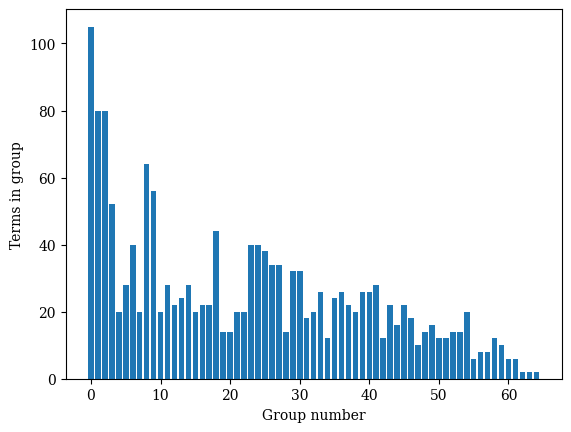

In [31]:
plt.bar(range(len(groups)), [len(group) for group in groups])
plt.xlabel("Group number")
plt.ylabel("Terms in group");

### Get measurement circuits

In [32]:
from diagonalize import diagonalize_pauli_strings

In [33]:
measurement_circuits = []
conjugated_paulis = []
for i, group in enumerate(groups_cirq):
    print(f"On group {i + 1} / {len(groups)}.", end="\r")
    meas_circuit, conjugated_strings = diagonalize_pauli_strings(group, cirq.LineQubit.range(nqubits))
    measurement_circuits.append(meas_circuit)
    conjugated_paulis.append(conjugated_strings)

On group 65 / 65.

#### Conversions

In [34]:
circuit_cirq = circuit_from_qasm(qasm2.dumps(base))

In [35]:
qmap = {qold: qnew for qold, qnew in zip(sorted(circuit_cirq.all_qubits()), cirq.LineQubit.range(nqubits))}
qmap

{cirq.NamedQubit('q_6'): cirq.LineQubit(0),
 cirq.NamedQubit('q_28'): cirq.LineQubit(1),
 cirq.NamedQubit('q_75'): cirq.LineQubit(2),
 cirq.NamedQubit('q_86'): cirq.LineQubit(3),
 cirq.NamedQubit('q_87'): cirq.LineQubit(4),
 cirq.NamedQubit('q_88'): cirq.LineQubit(5),
 cirq.NamedQubit('q_89'): cirq.LineQubit(6),
 cirq.NamedQubit('q_96'): cirq.LineQubit(7),
 cirq.NamedQubit('q_97'): cirq.LineQubit(8),
 cirq.NamedQubit('q_105'): cirq.LineQubit(9),
 cirq.NamedQubit('q_106'): cirq.LineQubit(10),
 cirq.NamedQubit('q_107'): cirq.LineQubit(11),
 cirq.NamedQubit('q_108'): cirq.LineQubit(12),
 cirq.NamedQubit('q_109'): cirq.LineQubit(13)}

In [36]:
circuit_cirq = circuit_cirq.transform_qubits(qmap)
circuit_cirq

┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────────────────────────────────────────────────────────────────┐                                                                                                                                                              

In [37]:
psi = cirq.Simulator().simulate(circuit_cirq).final_state_vector

In [38]:
qmap = {q: i for i, q in enumerate(hamiltonian_cirq.qubits)}

In [39]:
hamiltonian_cirq.expectation_from_state_vector(psi, qmap)

(-73.55058787146216+6.838701679102357e-15j)

#### Compute energy exactly after conversions + grouping

In [40]:
sum([len(group) for group in groups_cirq])

1619

In [41]:
len(list(hamiltonian_cirq))

1620

In [42]:
identity_term = list(hamiltonian_cirq)[0].coefficient
identity_term

(-46.85999302127529+0j)

In [43]:
expval = 0.0
for group in groups_cirq:
    expval += sum(group).expectation_from_state_vector(psi, qmap)
expval

(-26.690594850186738+6.83870167910269e-15j)

In [44]:
assert np.isclose(expval + identity_term, energy_exact)

In [45]:
to_run_cirq = [circuit_cirq + measurement_circuit for measurement_circuit in measurement_circuits]

In [46]:
psis = [cirq.Simulator().simulate(c).final_state_vector for c in to_run_cirq]

In [47]:
expval = 0.0
for pauli_list, psi in zip(conjugated_paulis, psis):
    expval += sum(pauli_list).expectation_from_state_vector(psi, qmap)
expval

(-26.690601266324453+2.5129257219464665e-16j)

In [48]:
assert np.isclose(expval + identity_term, energy_exact)

### Compute energy exactly after conversions + grouping with sampling

In [49]:
qubits_cirq = cirq.LineQubit.range(nqubits)

In [50]:
to_run_cirq_measured = []
for c in to_run_cirq:
    c = c.copy()
    c.append(cirq.measure(qubits_cirq, key="z"))
    to_run_cirq_measured.append(c)

In [51]:
all_counts = []
for c in to_run_cirq_measured:
    counts = cirq.Simulator().run(c, repetitions=nshots).histogram(key="z")
    all_counts.append(
        Counter({np.binary_repr(bitstring, width=nqubits): count for bitstring, count in counts.items()})
    )

In [52]:
from expectation import compute_expectation

In [53]:
expval = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts):
    expval += compute_expectation(sum(conjugated_group), counts)
expval

(-26.683103680594915-5.091931414595475e-12j)

In [58]:
assert np.isclose(expval + identity_term, energy_exact, atol=2.0 / np.sqrt(nshots))

### With Qiskit + sampling

In [59]:
to_run = [qiskit.QuantumCircuit.from_qasm_str(c.to_qasm()) for c in to_run_cirq]

In [60]:
for c in to_run:
    c.measure_active()

In [61]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    # initial_layout=layout
)

In [62]:
BASE: int = 16

all_counts_aer = []
for c in to_run:
    job = AerSimulator().run(c, shots=nshots)
    counts = Counter(
        {np.binary_repr(int(bitstring, BASE), nqubits): count for bitstring, count in job.result().data().get("counts").items()}
    )
    all_counts_aer.append(counts)

In [63]:
expval = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_aer):
    expval += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval

(-26.6961749761354+1.018386282919095e-11j)

In [65]:
assert np.isclose(expval + identity_term, energy_exact, atol=2.0 / np.sqrt(nshots))

## Run on hardware

In [66]:
job = sampler.run(to_run, shots=nshots)

In [67]:
all_counts_fez = []

In [68]:
res = job.result()

In [69]:
for r in res:
    all_counts_fez.append(r.data.meas.get_counts())

In [70]:
len(all_counts)

65

In [71]:
expval_fez = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_fez):
    expval_fez += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_fez

(-26.171882913200058-4.0056527128151077e-10j)

In [72]:
energy_fez = expval_fez + identity_term
energy_fez

(-73.03187593447535-4.0056527128151077e-10j)

In [73]:
energy_exact

(-73.55058787146216+6.838701679102357e-15j)

In [74]:
np.abs(np.real((energy_exact - energy_fez)) / np.real(energy_exact))

np.float64(0.0070524512719505545)

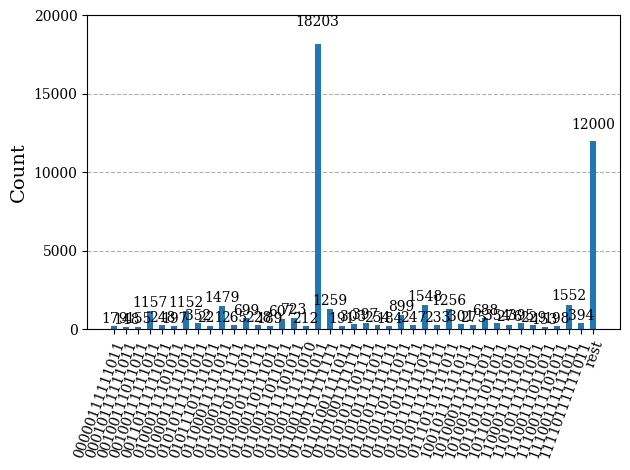

In [75]:
qiskit.visualization.plot_histogram(all_counts_fez[0], number_to_keep=40)

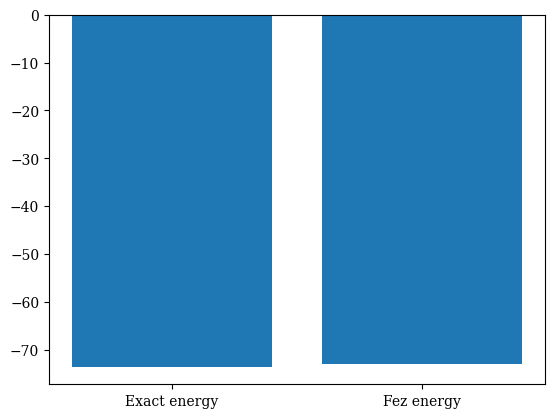

In [76]:
to_plot = [energy_exact.real, energy_fez.real]

plt.bar(["Exact energy", "Fez energy"], to_plot);

In [77]:
op_counts = Counter()
for c in to_run:
    for k, v in c.count_ops().items():
        op_counts[k] += v

In [78]:
ops = list(op_counts.keys())

In [79]:
op_counts = np.array(list(op_counts.values())) / len(to_run)

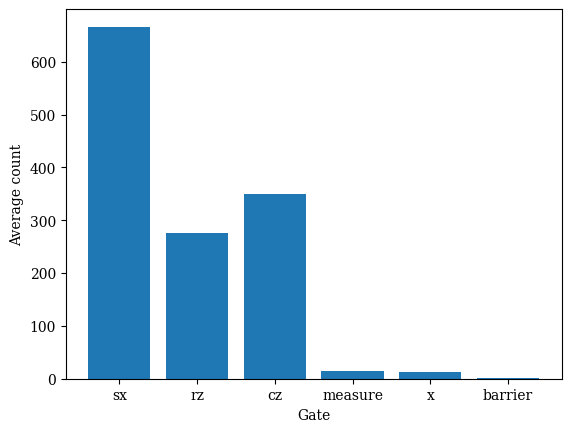

In [80]:
plt.bar(ops, op_counts)

plt.xlabel("Gate")
plt.ylabel("Average count");

## Save data

In [81]:
with open("all_circuits_fez_sep24.pkl", "wb") as file:
    pickle.dump(to_run, file)

with open("all_counts_fez_sep24.pkl", "wb") as file:
    pickle.dump(all_counts, file)

with open("all_conjugated_paulis_fez_sep24.pkl", "wb") as file:
    pickle.dump(conjugated_paulis, file)

## Begin QEM

## With fractional gates

In [ ]:
job_fractional_gates = sampler_fractional_gates.run([to_run], shots=nshots)

In [ ]:
all_counts_frac = [result.data.measure.get_counts() for result in job_fractional_gates.result()]

In [ ]:
counts_frac = [get_counts_for(c, qubit1, qubit2) for c in all_counts_frac][0]
counts_frac

In [ ]:
exp_zz_frac = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_frac.items()
) / nshots
exp_zz_frac

## With dynamical decoupling

In [ ]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [ ]:
job_dd = sampler_dd.run([to_run], shots=nshots)
# job_dd = service.job("d1vvt1okchbs73ca920g")

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [ ]:
counts_dd = [get_counts_for(c, qubit1, qubit2) for c in all_counts_dd][0]
counts_dd

In [ ]:
exp_zz_dd = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_dd.items()
) / nshots
exp_zz_dd

## With readout error mitigation

In [ ]:
from qiskit_experiments.library import LocalReadoutError
from qiskit.result.distributions.quasi import QuasiDistribution 

from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis

In [ ]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

In [ ]:
correction_matrices = []
for i in range(len(qubits)):
    correction_matrices.append(mitigator.mitigation_matrix(qubits[i]))

counts_per_bit = []
for i in range(len(qubits)):
    counts_per_bit.append(get_counts_for(all_counts[0],i))

margdist_per_bit = []
for i in range(len(qubits)):
    margdist_per_bit.append(np.array([counts_per_bit[i].get("0"), counts_per_bit[i].get("1")]) / nshots)

corrected_margdist_per_bit = []
for i in range(len(qubits)):
    corrected_margdist_per_bit.append(mitigator.mitigation_matrix(qubits[i]) @ margdist_per_bit[i])

new_bits = []
for i in range(len(qubits)):
    new_bits.append(np.random.choice([0, 1], size=nshots, p=corrected_margdist_per_bit[i]))

corrected_bitstrings = ["".join(str(new_bits[i][j]) for i in range(len(qubits))) for j in range(nshots)]
corrected_counts = Counter(corrected_bitstrings)

In [ ]:
def apply_rem(
    counts: dict[str, int], 
    mitigator: "qiskit_experiments.LocalReadoutMitigator",
    *qubits) -> dict[str: int]:
    counts = get_counts_for(counts, *qubits)
    vec = np.zeros(2 ** len(qubits), dtype=float)
    for bitstring, count in counts.items():
        vec[int(bitstring, 2)] = count
    vec = vec / nshots
    assert np.allclose(vec.sum(), 1.0)

    mitigated_probs_quasi = mitigator.mitigation_matrix(qubits=qubits) @ vec
    mitigated_probs_quasi = QuasiDistribution({i: v for i, v in enumerate(mitigated_probs_quasi)})
    mitigated_counts = {
        bitstring: int(nshots * prob) for bitstring, prob in mitigated_probs_quasi.nearest_probability_distribution().binary_probabilities().items()
    }
    return mitigated_counts

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts]

In [ ]:
exp_zz_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_rem[0].items()
) / nshots
exp_zz_rem

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_dd]

In [ ]:
exp_zz_dd_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd_rem[0].items()
) / nshots
exp_zz_dd_rem

## With ZNE

In [ ]:
from mitiq import zne

In [ ]:
qasm2_circuit = qasm2.dumps(compiled)

compiled_cirq = circuit_from_qasm(qasm2_circuit.replace("qregless", "q"))

In [ ]:
scale_factors = [1, 3, 5]

In [ ]:
scaled_circuits_cirq = [zne.scaling.fold_global(compiled_cirq, scale_factor) for scale_factor in scale_factors]

In [ ]:
scaled_circuits = [to_qiskit(circuit) for circuit in scaled_circuits_cirq]
scaled_circuits = qiskit.transpile(
    scaled_circuits,
    backend=computer,
    initial_layout=qubits,
    optimization_level=0,
)

In [ ]:
to_run_scaled = [get_measured_circuit(scaled_circuit) for scaled_circuit in scaled_circuits]

In [ ]:
job_zne = sampler.run(to_run_scaled, shots=nshots)
# job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [ ]:
all_counts_zne = [result.data.measure.get_counts() for result in job_zne.result()]

In [ ]:
counts_zne = [get_counts_for(c, qubit1, qubit2) for c in all_counts_zne]
counts_zne

In [ ]:
exp_zz_vals = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne
]
exp_zz_vals

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals,
    order=2,
)
exp_zz_zne

## ZNE + REM

In [ ]:
counts_zne_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_zne]

In [ ]:
exp_zz_vals_zne_rem = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne_rem
]
exp_zz_vals_zne_rem

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne_rem = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals_zne_rem,
    order=2,
)
exp_zz_zne_rem

## With decoherence renormalization

In [ ]:
from typing import List, Optional


def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

In [ ]:
echo = get_echo_circuit(computer, qubits, depth=4, seed=1)

In [ ]:
echo.count_ops()

In [ ]:
job_echo = sampler.run([echo], shots=nshots)

In [ ]:
all_counts_echo = [result.data.measure.get_counts() for result in job_echo.result()]

In [ ]:
renormalization = 1.0 - all_counts_echo[0].get("0" * len(qubits), 0) / nshots
renormalization

In [ ]:
exp_zz_drn = exp_zz / renormalization
exp_zz_drn

## Plot results

In [ ]:
labels_vals = {
    "Ideal": exp_zz_ideal,
    "Hardware": exp_zz,
    "DD": exp_zz_dd,
    "REM": exp_zz_rem,
    "DD+REM": exp_zz_dd_rem,
    "ZNE": exp_zz_zne,
    "ZNE+REM": exp_zz_zne_rem,
}
colors = ["tab:green", "tab:red", "tab:grey", "tab:orange", "tab:pink", "tab:blue", "salmon"]
vals = list(labels_vals.values())
labels = list(labels_vals.keys())

plt.bar(range(len(vals)), vals, tick_label=labels, color=colors, edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
plt.savefig("hchain_qem_v4.pdf")